# Proyek Klasifikasi Gambar: Cat vs Dog
- Nama: Naufal Arsapradhana
- Email: naufalarsa27@student.ub.ac.id
- ID Dicoding: MC006D5Y1477

# Import Library

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Resizing, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

import os
import shutil
import random
from tqdm import tqdm
import numpy as np
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

# Split Dataset

In [3]:
# Paths
original_dataset_dir = '/kaggle/input/dataset-catvsdog/dataset-catvsdog'  # update with your dataset folder name
base_dir = '/kaggle/working/dataset_split'

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Consistent lowercase folder names
splits = ['train', 'validation', 'test']
classes = ['cat', 'dog']

# Create destination folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Optional: remove wrongly named folders from earlier runs
for split in splits:
    split_path = os.path.join(base_dir, split)
    for folder in os.listdir(split_path):
        if folder.lower() not in classes:
            shutil.rmtree(os.path.join(split_path, folder))

# Function to split and copy images
def split_data(class_folder):
    src_dir = os.path.join(original_dataset_dir, class_folder)
    label = class_folder.lower()  # 'Cat' → 'cat', 'Dog' → 'dog'

    all_files = os.listdir(src_dir)
    random.shuffle(all_files)

    total = len(all_files)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    split_files = {
        'train': all_files[:train_end],
        'validation': all_files[train_end:val_end],
        'test': all_files[val_end:]
    }

    for split, file_list in split_files.items():
        for filename in file_list:
            src = os.path.join(src_dir, filename)
            dst = os.path.join(base_dir, split, label, filename)
            shutil.copy2(src, dst)

# Run splitting
split_data('Cat')
split_data('Dog')

print("✅ Dataset successfully split into train, validation, and test!")

✅ Dataset successfully split into train, validation, and test!


# Data Load


📂 Showing samples from TRAIN set:


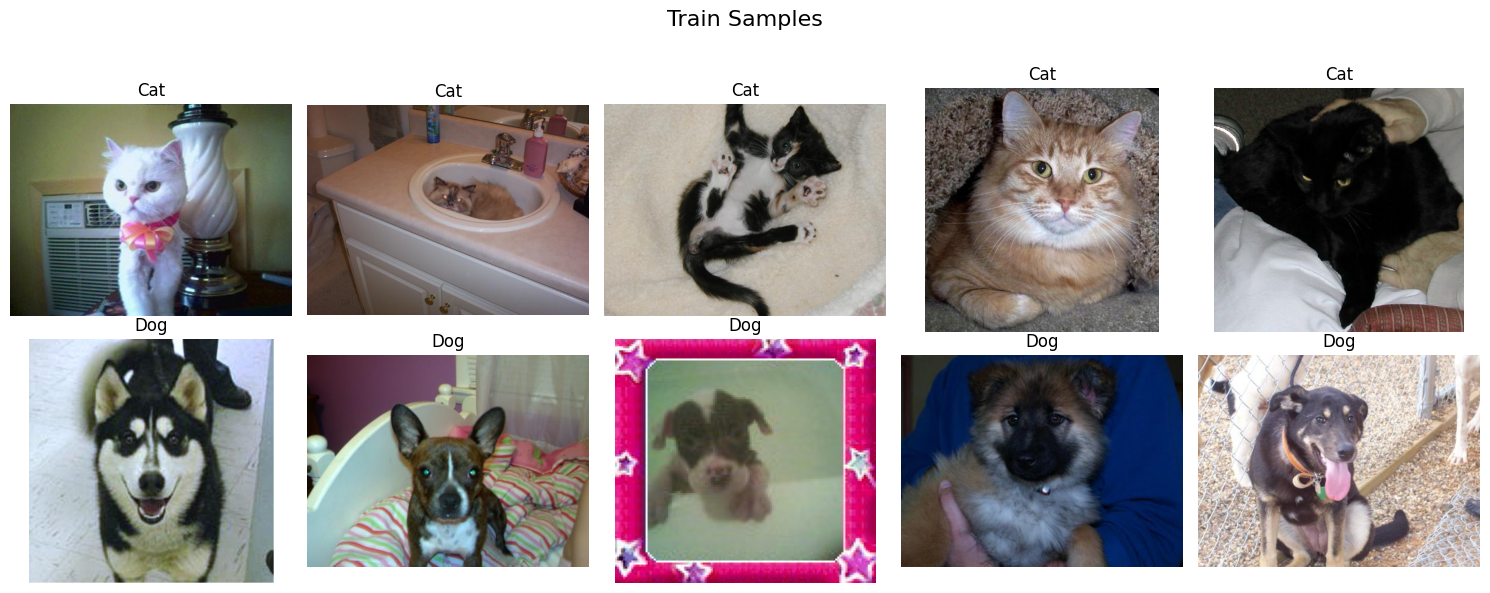


📂 Showing samples from VALIDATION set:


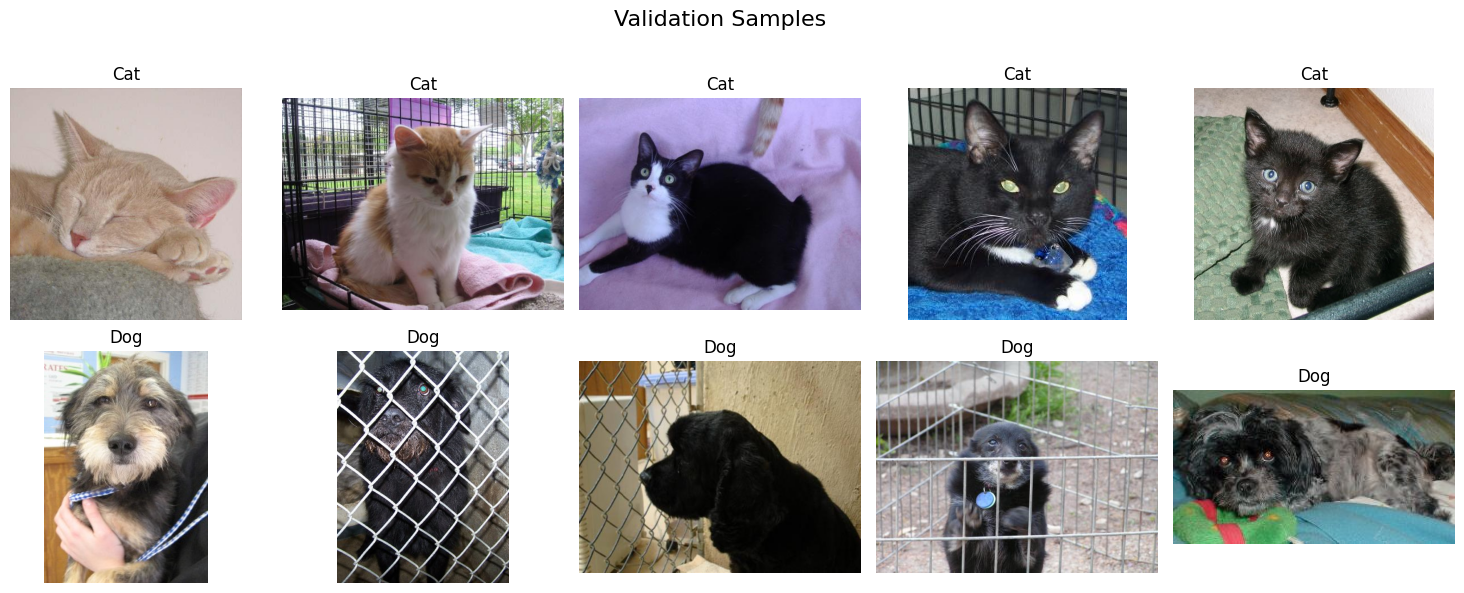


📂 Showing samples from TEST set:


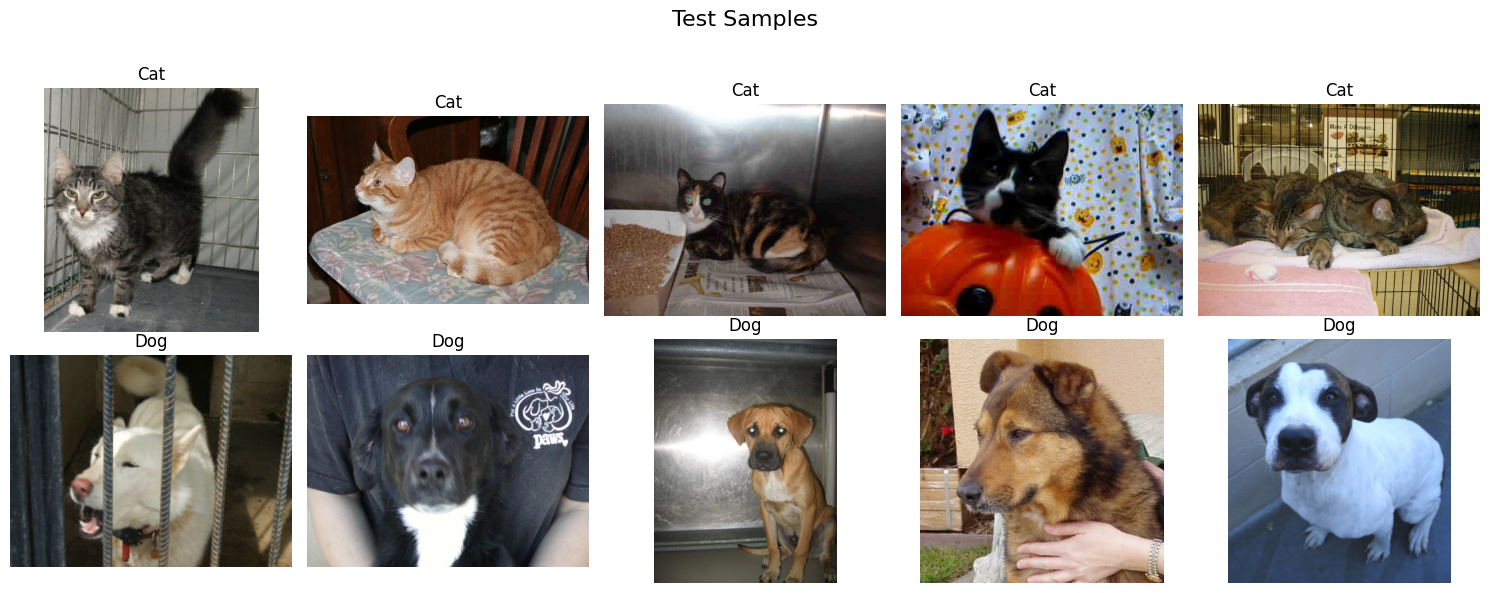

In [4]:
base_dir = '/kaggle/working/dataset_split' 

splits = ['train', 'validation', 'test']
categories = ['cat', 'dog']
samples_per_category = 5  # Number of images to show per category per split

# Display images
for split in splits:
    print(f"\n📂 Showing samples from {split.upper()} set:")
    fig, axs = plt.subplots(2, samples_per_category, figsize=(samples_per_category * 3, 6))
    fig.suptitle(f'{split.capitalize()} Samples', fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, split, category)
        image_files = os.listdir(category_path)
        sample_files = random.sample(image_files, samples_per_category)

        for j, file in enumerate(sample_files):
            img_path = os.path.join(category_path, file)
            image = Image.open(img_path)
            axs[i][j].imshow(image)
            axs[i][j].axis('off')
            axs[i][j].set_title(f'{category.capitalize()}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Data Cleaning

In [6]:
folder = '/kaggle/working/dataset_split/train/cat'
files_to_remove1 = ['666.jpg']

for fname in files_to_remove1:
    file_path = os.path.join(folder, fname)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"🗑️ Removed: {fname}")
    else:
        print(f"❌ Not found: {fname}")

🗑️ Removed: 666.jpg


In [8]:
folder = '/kaggle/working/dataset_split/train/cat'
files_to_remove2 = ['10404.jpg']

for fname in files_to_remove2:
    file_path = os.path.join(folder, fname)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"🗑️ Removed: {fname}")
    else:
        print(f"❌ Not found: {fname}")

🗑️ Removed: 10404.jpg


In [9]:
folder = '/kaggle/working/dataset_split/train/dog'
files_to_remove = ['11702.jpg']

for fname in files_to_remove:
    file_path = os.path.join(folder, fname)
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"🗑️ Removed: {fname}")
    else:
        print(f"❌ Not found: {fname}")

🗑️ Removed: 11702.jpg


# Data Splitting

In [10]:
# Paths
train_dir = '/kaggle/working/dataset_split/train'
val_dir = '/kaggle/working/dataset_split/validation'
test_dir = '/kaggle/working/dataset_split/test'

# Image dimensions
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
def filter_image_files(directory):
    """Filters out non-image files and returns a list of image paths."""
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(image_extensions) and os.path.isfile(os.path.join(directory, f))]


# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 17497 images belonging to 2 classes.
Found 3748 images belonging to 2 classes.
Found 3752 images belonging to 2 classes.


# Build Model

## Model Sequential

In [25]:
seq_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Custom callback to save the best model when accuracy reaches 95%
class SaveBestModelAtAccuracy(Callback):
    def __init__(self, accuracy_threshold=0.85, save_path='seq_best_model.keras'):
        super(SaveBestModelAtAccuracy, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        # Check if accuracy has reached the threshold
        if logs.get('accuracy') >= self.accuracy_threshold:
            print(f"\nEpoch {epoch + 1}: accuracy reached {self.accuracy_threshold * 100}%, saving model.")
            self.model.save(self.save_path)


checkpoint_seq = ModelCheckpoint(
    'seq_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

earlystop_seq = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_seq = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

accuracy_seq = SaveBestModelAtAccuracy(accuracy_threshold=0.95, save_path='seq_best_model_accuracy')

# Combine callbacks
callbacks_seq = [checkpoint_seq, earlystop_seq, reduce_lr_seq, accuracy_seq]

# Compile model
seq_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train model
history_seq = seq_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks_seq
)

Epoch 1/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5335 - loss: 0.6984
Epoch 1: val_loss improved from inf to 0.63912, saving model to seq_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 112s 191ms/step - accuracy: 0.5336 - loss: 0.6983 - val_accuracy: 0.6465 - val_loss: 0.6391 - learning_rate: 0.0010
Epoch 2/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6237 - loss: 0.6501
Epoch 2: val_loss improved from 0.63912 to 0.59450, saving model to seq_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 103s 185ms/step - accuracy: 0.6237 - loss: 0.6500 - val_accuracy: 0.6873 - val_loss: 0.5945 - learning_rate: 0.0010
Epoch 3/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6783 - loss: 0.6052
Epoch 3: val_loss improved from 0.59450 to 0.52832, saving model to seq_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 103s 186ms/step - accuracy: 0.6783 - loss: 0.6051 - val_accuracy: 0.7463 - val_loss: 0.5283 - learning_rate: 0.0010
Epoch 4/20
546/547 ━━━━━━━━━━━━━━━━━━━

In [26]:
test_loss, test_acc = seq_model.evaluate(test_generator)
print(f"✅ Model Sequential Test Accuracy: {test_acc * 100:.2f}%")

118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8473 - loss: 0.3277
✅ Model Sequential Test Accuracy: 88.03%


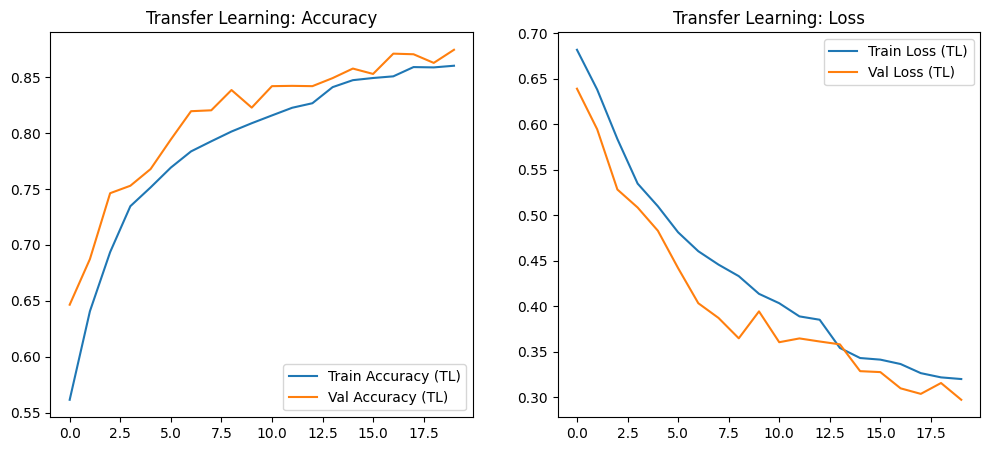

In [27]:
seq_acc = history_seq.history['accuracy']
seq_val_acc = history_seq.history['val_accuracy']
seq_loss = history_seq.history['loss']
seq_val_loss = history_seq.history['val_loss']
seq_epochs_range = range(len(seq_acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(seq_epochs_range, seq_acc, label='Train Accuracy (TL)')
plt.plot(seq_epochs_range, seq_val_acc, label='Val Accuracy (TL)')
plt.legend(loc='lower right')
plt.title('Transfer Learning: Accuracy')

plt.subplot(1, 2, 2)
plt.plot(seq_epochs_range, seq_loss, label='Train Loss (TL)')
plt.plot(seq_epochs_range, seq_val_loss, label='Val Loss (TL)')
plt.legend(loc='upper right')
plt.title('Transfer Learning: Loss')
plt.show()

# Save Model

In [28]:
# Load.keras model
model = tf.keras.models.load_model('/kaggle/working/seq_best_model.keras')

# Export it in SavedModel format (for TFLite/TF.js)
model.export('/kaggle/working/best_model_savedmodel')

Saved artifact at '/kaggle/working/best_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_20')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134926816640464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926816639696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926816628944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926816628560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926815184272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926815185040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926815185424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926815186384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926815186576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926815187152: TensorSpec(shape=(), dtype=tf.resource, name

## TF-Lite

In [30]:
converter = tf.lite.TFLiteConverter.from_saved_model('/kaggle/working/best_model_savedmodel')
tflite_model = converter.convert()

with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

W0000 00:00:1745027925.308920      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745027925.308956      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


## TFJS

In [31]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 

In [32]:
!tensorflowjs_converter --input_format=tf_saved_model /kaggle/working/best_model_savedmodel /kaggle/working/tfjs_model/

2025-04-19 01:59:18.059638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745027958.081762     592 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745027958.088039     592 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1745027965.010682     592 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11776 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745027965.011347     592 gpu_device.cc:2022] Created device /job:localhost/replica:0

# Inference

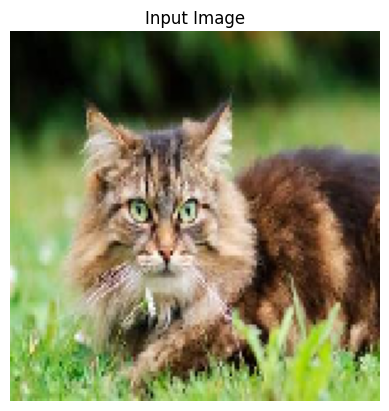

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Prediction score: [[0.10762929]]
Class: Cat


In [38]:
# Load model
model = tf.keras.models.load_model('/kaggle/working/seq_best_model.keras')

# Load image
img_path = '/kaggle/input/inference1/th.jpeg'
img = image.load_img(img_path, target_size=(150, 150))

# Show Image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess Image
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
print("Prediction score:", prediction)
print("Class:", "Dog" if prediction[0][0] > 0.5 else "Cat")

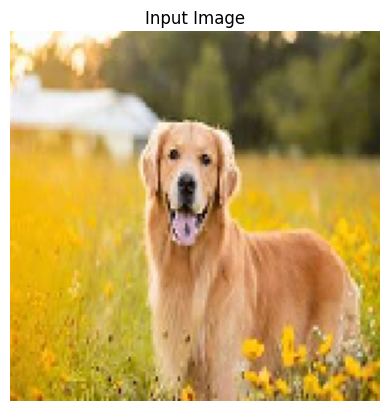

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Prediction score: [[0.9893862]]
Class: Dog


In [39]:
# Load model
model = tf.keras.models.load_model('/kaggle/working/seq_best_model.keras')

# Load image
img_path = '/kaggle/input/inference2/th (1).jpeg'
img = image.load_img(img_path, target_size=(150, 150))  # Use your IMG_SIZE

# Show Image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess Image
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
prediction = model.predict(img_array)
print("Prediction score:", prediction)
print("Class:", "Dog" if prediction[0][0] > 0.5 else "Cat")